# Importing necessary libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np


In [ ]:
loaded_vectorizer = joblib.load('/content/drive/MyDrive/AI_Content_Detector/new_model_tfidf/tfidf_vectorizer.joblib')

In [ ]:
models = {
    "XGBoost": joblib.load('/content/drive/MyDrive/AI_Content_Detector/new_model_tfidf/XGBoost_model.joblib'),
    "SVM_model": joblib.load('/content/drive/MyDrive/AI_Content_Detector/new_model_tfidf/SVM_model.joblib'),
    "Naive_Bayes": joblib.load('/content/drive/MyDrive/AI_Content_Detector/new_model_tfidf/Naive Bayes_model.joblib'),
    "Random_forest": joblib.load('/content/drive/MyDrive/AI_Content_Detector/new_model_tfidf/Random Forest_model.joblib')
}

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_syste

In [ ]:
from datasets import load_dataset,concatenate_datasets

ds = load_dataset("Jinyan1/COLING_2025_MGT_en")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/588 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/287M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/286M [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/610767 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/261758 [00:00<?, ? examples/s]

In [ ]:
train_dataset = ds['train']

In [ ]:
label_0_samples = train_dataset.filter(lambda x: x['label'] == 0).select(range(2000))
label_1_samples = train_dataset.filter(lambda x: x['label'] == 1).select(range(2000))


Filter:   0%|          | 0/610767 [00:00<?, ? examples/s]

Filter:   0%|          | 0/610767 [00:00<?, ? examples/s]

In [ ]:
balanced_dataset = concatenate_datasets([label_0_samples, label_1_samples]).shuffle(seed=42)


In [ ]:
# Keep only 'label' and 'text' columns
final_dataset = balanced_dataset.remove_columns(['id', 'source', 'sub_source', 'lang', 'model'])

# Print the result
print(final_dataset)

Dataset({
    features: ['label', 'text'],
    num_rows: 4000
})


In [ ]:
# Convert to Pandas DataFrame
data = final_dataset.to_pandas()

# Display first few rows of the DataFrame
print(data.head())

   label                                               text
0      0  small amount of money gets used very often if ...
1      0  Drink some carbonated water with no flavoring ...
2      0  Hateful 8 was shot in a system called [Ultra P...
3      1  The appendix is a small sac-like organ attache...
4      1  [step] Click on the object you have created. E...


Results for XGBoost:
Accuracy: 0.6080
Precision: 0.6106
Recall: 0.6080
F1 Score: 0.6057




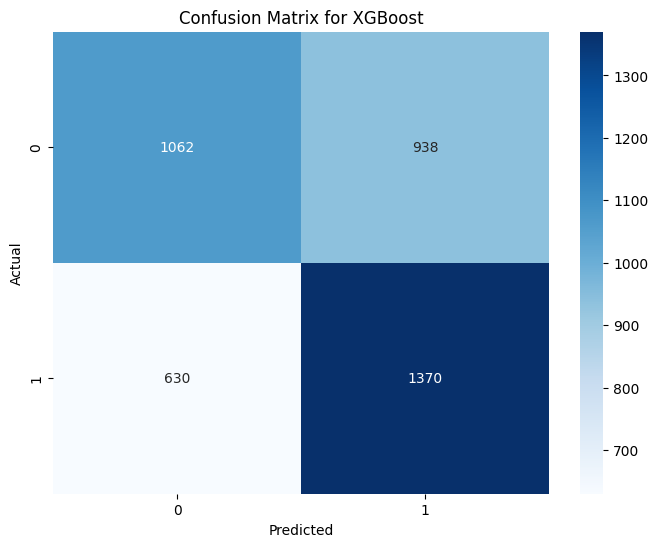

Results for SVM_model:
Accuracy: 0.6298
Precision: 0.6298
Recall: 0.6298
F1 Score: 0.6297




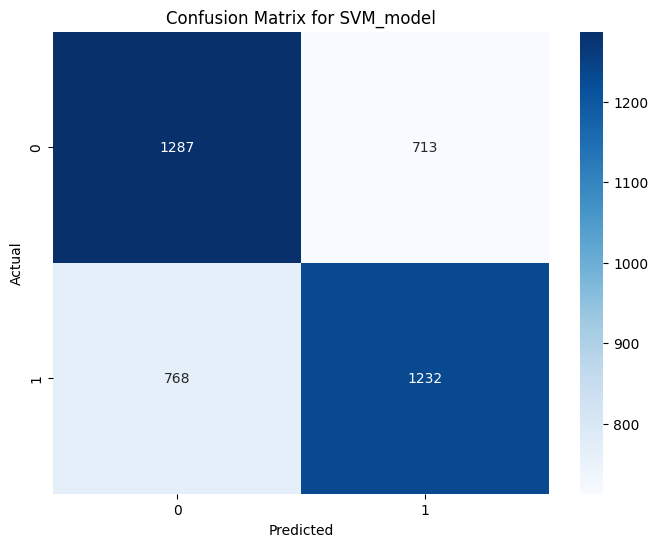

Results for Naive_Bayes:
Accuracy: 0.5650
Precision: 0.5808
Recall: 0.5650
F1 Score: 0.5427




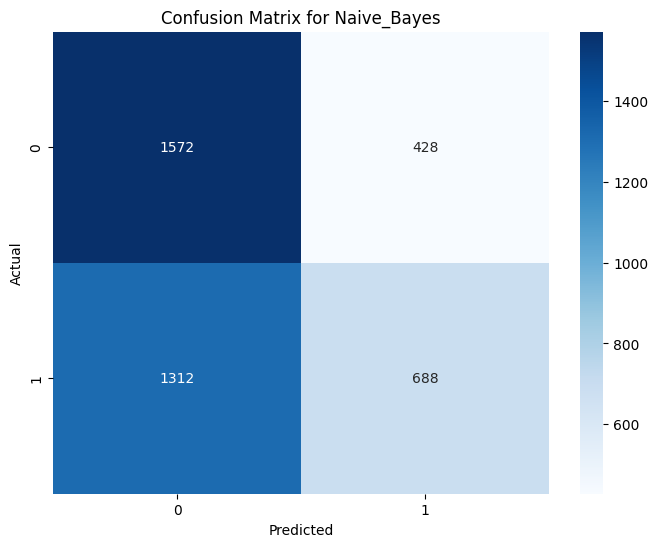

Results for Random_forest:
Accuracy: 0.5820
Precision: 0.5857
Recall: 0.5820
F1 Score: 0.5775




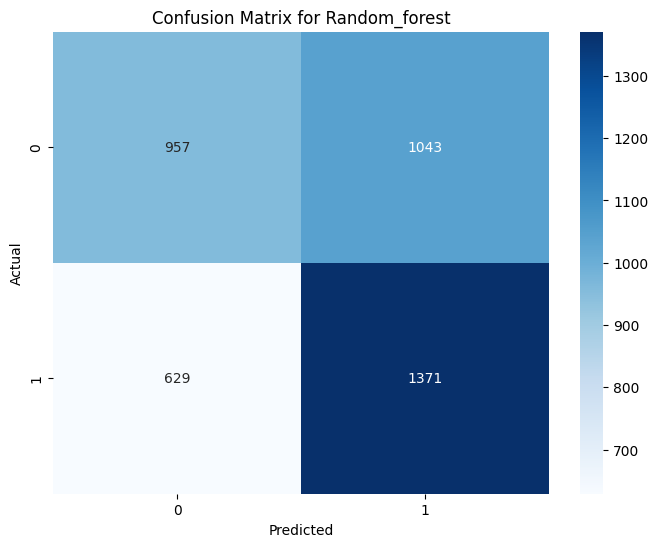

In [ ]:
# Preprocess the text data using the loaded vectorizer
X_sparse = loaded_vectorizer.transform(data['text'])  # Transform the text
y = data['label']  # Ground truth labels

# Convert sparse matrix to dense array for models that require it
X_dense = X_sparse.toarray()

# Evaluate each model
for model_name, model in models.items():
    # Check if the model supports sparse input; if not, use dense
    if hasattr(model, 'predict_proba'):  # Example check (SVM might not support sparse)
        y_pred = model.predict(X_dense)
    else:
        y_pred = model.predict(X_sparse)

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    # Display metrics
    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\n")

    # Compute and display confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()